In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from calflops import calculate_flops
work_path = "/home/re6125015/DeepL/images"
os.chdir(work_path)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # You can choose any seed value

/opt/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.getpid()

244919

In [3]:
def load_npz_data(file_path):
    loaded = np.load(file_path)
    X = loaded['array1']  # Adjust 'array1' if your image data key is different
    y = loaded['array2']  # Adjust 'array2' if your label data key is different
    return X, y

X_train, y_train = load_npz_data('train.npz')
X_val, y_val = load_npz_data('val.npz')
X_test, y_test = load_npz_data('test.npz')

In [4]:
class NPZDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)  # Ensure label is torch.long

In [5]:
res = 84
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((res, res)),  # ResNet typically uses 224x224 input images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = NPZDataset(X_train, y_train, transform=transform)
val_dataset = NPZDataset(X_val, y_val, transform=transform)
test_dataset = NPZDataset(X_test, y_test, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [6]:
class DynamicSelectiveConvLayer(nn.Module):
    def __init__(self, max_channels, out_channels, kernel_size, stride=1, padding=1, bias=False, dropout_rate=0.5):
        super(DynamicSelectiveConvLayer, self).__init__()
        self.max_channels = max_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bias_param = bias
        self.dropout_rate = dropout_rate
        
        self.weight_gens = nn.ModuleDict({
            f"{i}": nn.Linear(i, out_channels * i * kernel_size * kernel_size)
            for i in range(1, max_channels + 1)
        })
        
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.register_parameter('bias', None)

    def forward(self, x, selected_channels=None):
        device = x.device
        
        if self.training:
            # Randomly drop channels with controlled probability
            if torch.rand(1).item() < self.dropout_rate:
                max_channel_count = x.size(1)
                selected_channels = torch.randperm(max_channel_count)[:torch.randint(1, max_channel_count+1, (1,)).item()].tolist()
            else:
                selected_channels = list(range(x.size(1)))
        
        if max(selected_channels) >= self.max_channels:
            raise ValueError("selected_channels must be less than max_channels")

        # Generate channel mask
        channel_mask = torch.zeros(self.max_channels, dtype=torch.bool, device=device)
        channel_indices = torch.tensor(selected_channels, dtype=torch.long, device=device)
        channel_mask[channel_indices] = True
        
        # Apply mask to filter out unwanted channels
        x_selected = x[:, channel_mask, :, :]
        
        # Generate dynamic weights according to the number of selected channels
        num_selected_channels = x_selected.size(1)
        avg_pool = F.adaptive_avg_pool2d(x_selected, 1).view(x_selected.size(0), -1)
        dynamic_weights = self.weight_gens[f"{num_selected_channels}"](avg_pool)
        dynamic_weights = dynamic_weights.view(x.size(0), self.out_channels, num_selected_channels, self.kernel_size, self.kernel_size)

        # Perform convolution using grouped convolution to process all batches simultaneously
        batch_size = x_selected.size(0)
        x_selected = x_selected.view(1, batch_size * num_selected_channels, x_selected.size(2), x_selected.size(3))
        dynamic_weights = dynamic_weights.view(batch_size * self.out_channels, num_selected_channels, self.kernel_size, self.kernel_size)
        
        output = F.conv2d(x_selected, dynamic_weights, None, self.stride, self.padding, groups=batch_size)
        output = output.view(batch_size, self.out_channels, output.size(2), output.size(3))
        
        if self.bias is not None:
            output += self.bias.view(1, -1, 1, 1)
        
        return output

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = DynamicSelectiveConvLayer(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x, selected_channels = [0, 1, 2]):
        x = self.conv1(x, selected_channels)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# # Define a StepLR scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [10]:
batch_size = 64
input_shape = (batch_size, 3, 84, 84)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  11.2 M  
fwd MACs:                                                               67.7947 GMACs
fwd FLOPs:                                                              135.889 GFLOPS
fwd+bwd MACs:                                                           203.384 GMACs
fwd+bwd FLOPs:                                                          407.667 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each mo

/home/re6125015/.local/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Train Loss: 3.4945 Train Acc: 9.64% Val Loss: 3.2456 Val Acc: 12.67%
Epoch 2: Train Loss: 3.0524 Train Acc: 17.32% Val Loss: 2.9151 Val Acc: 19.56%
Epoch 3: Train Loss: 2.7983 Train Acc: 23.28% Val Loss: 2.7947 Val Acc: 23.78%
Epoch 4: Train Loss: 2.5918 Train Acc: 27.70% Val Loss: 2.5655 Val Acc: 29.33%
Epoch 5: Train Loss: 2.3814 Train Acc: 32.79% Val Loss: 2.5988 Val Acc: 29.11%
Epoch 6: Train Loss: 2.2127 Train Acc: 36.34% Val Loss: 2.4572 Val Acc: 31.33%
Epoch 7: Train Loss: 2.0153 Train Acc: 41.25% Val Loss: 2.1162 Val Acc: 40.22%
Epoch 8: Train Loss: 1.8676 Train Acc: 45.10% Val Loss: 1.9281 Val Acc: 44.67%
Epoch 9: Train Loss: 1.7309 Train Acc: 48.25% Val Loss: 2.1772 Val Acc: 39.56%
Epoch 10: Train Loss: 1.6016 Train Acc: 52.05% Val Loss: 2.1841 Val Acc: 40.00%
Epoch 11: Train Loss: 1.4598 Train Acc: 55.41% Val Loss: 1.9883 Val Acc: 46.44%
Epoch 12: Train Loss: 1.3705 Train Acc: 57.73% Val Loss: 2.0991 Val Acc: 43.11%
Epoch 13: Train Loss: 1.2377 Train Acc: 61.74% Val

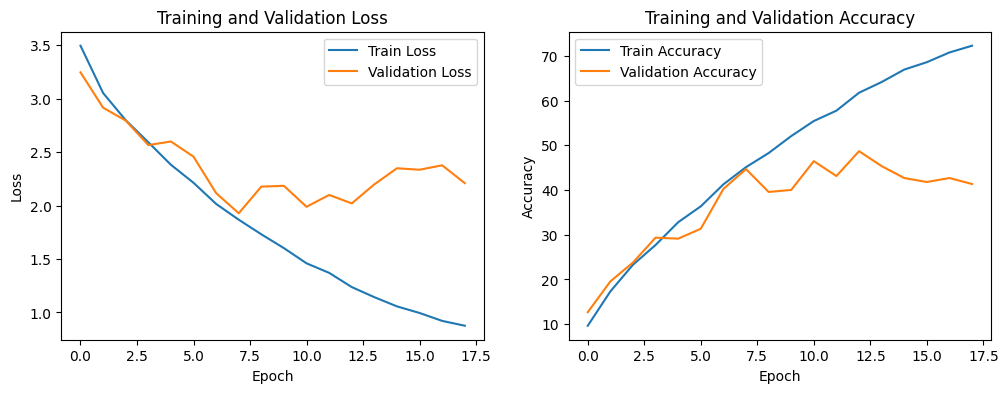

In [11]:
num_epochs = 50
early_stopping_counter = 0
best_val_acc = 0.0
selected_channels = [0, 1, 2] 

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs, selected_channels)
        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
        optimizer.step()  # Optimize the model

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, selected_channels)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct / total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch + 1}: Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.2f}% Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')

    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f'part1/best_model_v4_{res}.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter > 4:  # Stops if no improvement after 4 epochs
        print("Early stopping triggered.")
        break

# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [12]:
print(best_val_acc)

48.66666666666667


In [13]:
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50)
model.load_state_dict(torch.load(f'part1/best_model_v4_{res}.pth'))
model.eval()  # Set the model to evaluation mode
model.to(device)  # Move model to the appropriate device (CPU or GPU)

ResNet(
  (conv1): DynamicSelectiveConvLayer(
    (weight_gens): ModuleDict(
      (1): Linear(in_features=1, out_features=576, bias=True)
      (2): Linear(in_features=2, out_features=1152, bias=True)
      (3): Linear(in_features=3, out_features=1728, bias=True)
    )
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=

In [14]:
# Function to make predictions and optionally evaluate the model with selected channels
def predict(model, data_loader, selected_channels):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_predictions = []
    all_labels = []  # Optional, only if labels are available in the test set

    with torch.no_grad():  # No need to track gradients for predictions
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            # Update the model call to include selected_channels
            outputs = model(inputs, selected_channels)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())  # Optional

    return all_predictions, all_labels

# Example of using the updated predict function
selected_channels = [0, 1, 2]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)

In [15]:
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data: {accuracy:.2f}%")

Accuracy on test data: 46.44%


In [16]:
# Example of saving predictions to a CSV file
result_df = pd.DataFrame({'PredictedLabel': predictions})
result_df.to_csv(f'part1/predict_rgb_v4_{res}.csv', index=False)

In [19]:
selected_channels = [0, 1]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (RG): {accuracy:.2f}%")

Accuracy on test data (RG): 26.89%


In [20]:
selected_channels = [0, 2]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (RB): {accuracy:.2f}%")

Accuracy on test data (RB): 31.78%


In [21]:
selected_channels = [1, 2]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (GB): {accuracy:.2f}%")

Accuracy on test data (GB): 28.89%


In [22]:
selected_channels = [0]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (R): {accuracy:.2f}%")

Accuracy on test data (R): 15.11%


In [23]:
selected_channels = [1]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (G): {accuracy:.2f}%")

Accuracy on test data (G): 17.78%


In [24]:
selected_channels = [2]  # For example, use only Red and Green channels
predictions, labels = predict(model, test_loader, selected_channels)
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data (B): {accuracy:.2f}%")

Accuracy on test data (B): 19.11%


In [17]:
# Print classification report
print("Classification Report:")
print(classification_report(labels, predictions))

# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(labels, predictions)
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.22      0.27         9
           1       0.41      0.78      0.54         9
           2       0.36      0.44      0.40         9
           3       0.67      0.22      0.33         9
           4       0.60      0.67      0.63         9
           5       0.42      0.89      0.57         9
           6       0.50      0.22      0.31         9
           7       0.50      0.44      0.47         9
           8       0.36      0.44      0.40         9
           9       0.20      0.22      0.21         9
          10       0.43      0.33      0.38         9
          11       0.20      0.22      0.21         9
          12       0.67      0.44      0.53         9
          13       0.23      0.33      0.27         9
          14       0.20      0.33      0.25         9
          15       0.55      0.67      0.60         9
          16       0.50      0.22      0.31         9
    

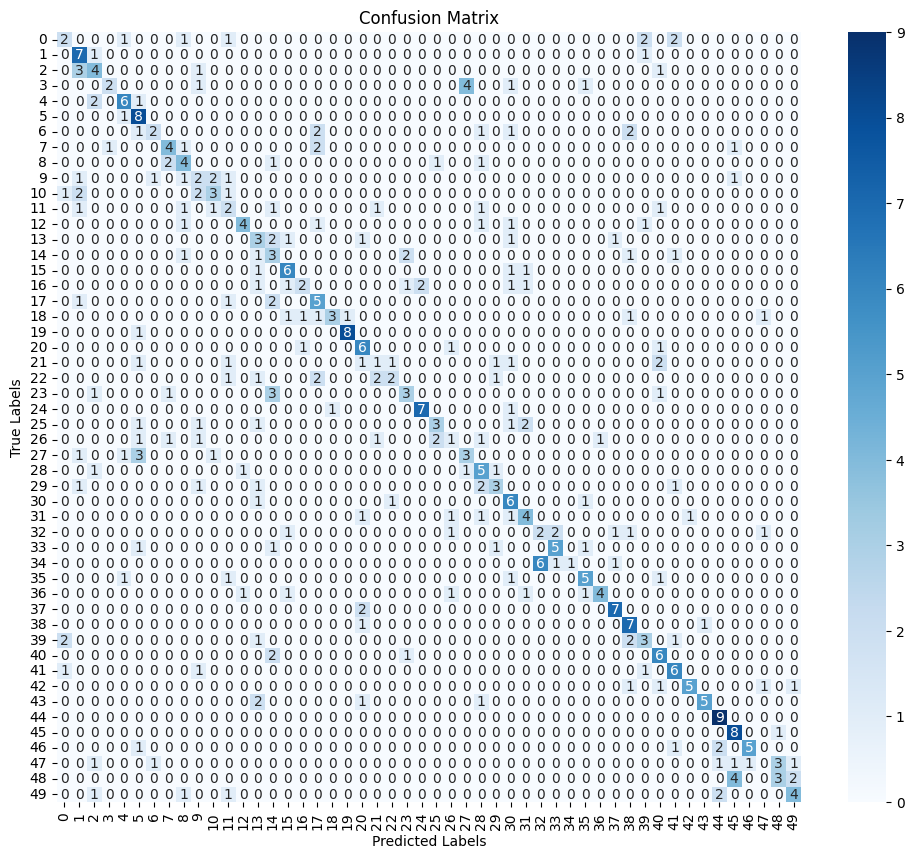

In [18]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()